# Generating simulated data

This notebook details the method *run()*, which simulates data when variables or models are changed.

## Import and settings

In [1]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.base import BaseEstimator, ClassifierMixin, RegressorMixin
from scipy.special import expit

from IPython.display import display, Markdown
import matplotlib.pyplot as plt
import networkx as nx

from lingam.causal_based_simulator import CausalBasedSimulator
from lingam.utils import make_dot

np.set_printoptions(precision=3, suppress=True)
np.random.seed(0)

## Creating test data
Create test data with variables from x0 to x5, of which x2 is a categorical variable.

### Causal graph

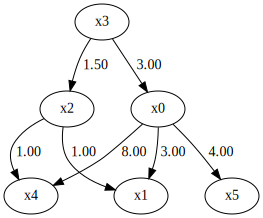

### Test data

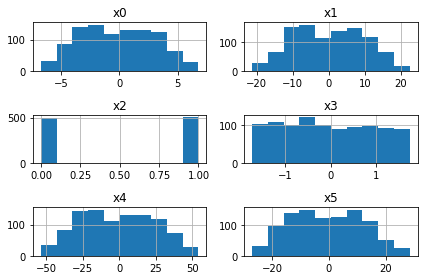

In [2]:
display(Markdown("### Causal graph"))

G = np.array([[0.0, 0.0, 0.0, 3.0, 0.0, 0.0],
              [3.0, 0.0, 1.0, 0.0, 0.0, 0.0],
              [0.0, 0.0, 0.0, 1.5, 0.0, 0.0],
              [0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
              [8.0, 0.0, 1.0, 0.0, 0.0, 0.0],
              [4.0, 0.0, 0.0, 0.0, 0.0, 0.0]])

causal_order = [3, 2, 0, 4, 1, 5]

display(make_dot(G))

display(Markdown("### Test data"))

N = 1000
n_features = len(G)
discrete_index = 2

e = np.random.uniform(-np.sqrt(3), np.sqrt(3), size=(n_features, N))
X = np.empty((n_features, N))
for i in causal_order:
    X[i] = G[i] @ X + e[i]
    if i == discrete_index:
        X[i] = (expit(X[i]) >= np.random.uniform(size=N)).astype(int)
X = pd.DataFrame(X.T, columns=[f"x{i}" for i in range(n_features)])

X[f"x{discrete_index}"] = X[f"x{discrete_index}"].astype(int)

X.hist()
plt.tight_layout()
plt.show()

## Simulation

Running *run()* after running *train()* will simulate data based on the data and the causal graph given at *train()*.

It is also possible to give run() an argument *changing_models* to change the model and an argument *changing_exog* to change the error data.

Let's first run without setting any optional arguments.

In [3]:
sim = CausalBasedSimulator()
sim.train(X, G)

sim_df = sim.run()
sim_df

,x0,x1,x2,x3,x4,x5
0,-0.725033,-0.853352,1.0,-0.298043,-5.518573,-3.361619
1,2.092471,5.580223,1.0,0.449011,17.970192,7.668833
2,3.251115,10.669606,1.0,0.965044,25.752890,11.510047
3,3.808976,13.150129,1.0,1.217832,30.951193,14.725043
4,3.023790,8.491654,1.0,1.096086,23.642615,11.167459
...,...,...,...,...,...,...
995,-2.956283,-6.859822,1.0,-0.520865,-23.626605,-13.196111
996,-0.625121,-0.109110,1.0,-0.225604,-4.917385,-3.749196
997,4.948195,14.775676,0.0,1.143164,38.537282,20.473555
998,3.557858,12.171933,1.0,1.499285,29.111905,14.174955


The simulation results are returned as the return value of run().

In *train()*, the causal graph was analyzed to find the parent-child relationship of each variable, and the data corresponding to the explanatory variables were extracted from the argument data frame *X*. However, *run()* does not extract the values of the explanatory variables from *X*. Instead, it uses the predictions of the parent model as the values of the explanatory variables.

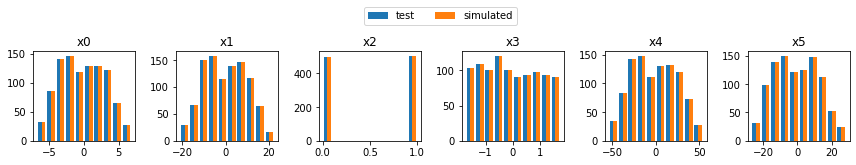

In [4]:
fig, axes = plt.subplots(1, sim_df.shape[1], figsize=(2 * sim_df.shape[1], 2))

for ax, column_name in zip(axes, sim_df.columns):
    ax.hist((X[column_name], sim_df[column_name]), label=("test", "simulated"))
    ax.set_title(column_name)
    
plt.tight_layout()
axes[0].legend(bbox_to_anchor=(4, 1.4), ncol=2, loc="center")
plt.show()

The simulation returns the model's predictions plus the residuals from the training to be the same as the test data, so for this simple data set, the distribution of the simulated and test data is almost equal.

If we subtract the residuals from the simulated results, we get the following. However, x2 is a categorical variable, x3 is most upstream variable, so they do not have residuals.

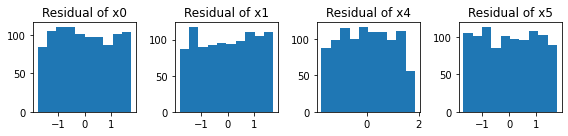

In [5]:
target_names = ["x0", "x1", "x4", "x5"]

fig, axes = plt.subplots(1, len(target_names), figsize=(2 * len(target_names), 2))

for i, target_name in enumerate(target_names):
    res = sim.train_result_[target_name]["residual"]
    axes[i].hist(res)
    axes[i].set_title("Residual of " + target_name)
    
plt.tight_layout()
plt.show()

## Simulation by changing exogenous variables

Simulation can also be performed by changing the exogenous variables for each variable. Check the distribution of the exogenous variables of *x0* (residuals at training) and change the exogenous variables. By changing the exogenous variable for *x0*, you will see that *x1*, *x4*, and *x5*, which are descendants of *x0*, are also affected.

In [6]:
sim = CausalBasedSimulator()
sim.train(X, G)

Histogram of residual of x0 is following:

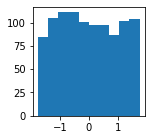

In [7]:
plt.figure(figsize=(2, 2))
plt.hist(sim.train_result_["x0"]["residual"])
plt.show()

In [8]:
changing_exog = {
    "x0": np.random.laplace(0, 1, size=X.shape[0])
}
sim_df = sim.run(changing_exog=changing_exog)

Histograms of the test data and the simulated data are as follows:

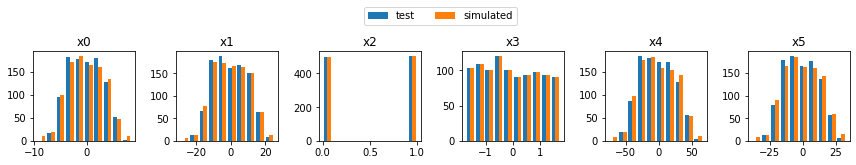

In [9]:
fig, axes = plt.subplots(1, sim_df.shape[1], figsize=(2 * sim_df.shape[1], 2))

for ax, column_name in zip(axes, sim_df.columns):
    ax.hist((X[column_name], sim_df[column_name]), label=("test", "simulated"))
    ax.set_title(column_name)
    
plt.tight_layout()
axes[0].legend(bbox_to_anchor=(4, 1.4), ncol=2, loc="center")
plt.show()

## Change model and simulate

Simulate by replacing the regression model for *x0* with another trained regression model. Change to a linear regression model that treats the coefficients of *x3* four times as heavily as the model for *x0*.

In [10]:
sim = CausalBasedSimulator()
sim.train(X, G)

# before changing the model of x0
sim_df = sim.run()

parent_names = sim.train_result_["x0"]["parent_names"]
coef = sim.train_result_["x0"]["model"].coef_
coef = [coef[parent_names.index("x3")] * 4]

changing_models = {
    "x0": {
        "parent_names": parent_names,
        "coef": coef,
    },
}
sim_df2 = sim.run(changing_models=changing_models)

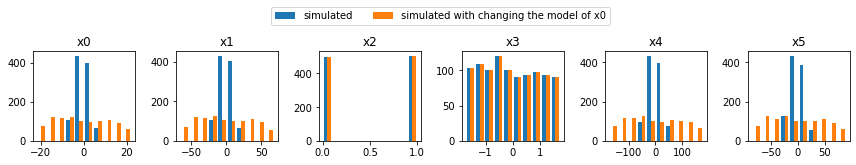

In [11]:
fig, axes = plt.subplots(1, sim_df.shape[1], figsize=(2 * sim_df.shape[1], 2))

for ax, column_name in zip(axes, sim_df.columns):
    ax.hist((sim_df[column_name], sim_df2[column_name]), label=("simulated", "simulated with changing the model of x0"))
    ax.set_title(column_name)
    
plt.tight_layout()
axes[0].legend(bbox_to_anchor=(4, 1.4), ncol=2, loc="center")
plt.show()

You can see that changing the model of *x0* and simulating it produces a different result than before the model change. The simulation values are created by adding the residuals from the output of *train()* to the model's predictions. Since we have changed to a model with large coefficients, the predictions of the model are larger and the simulation values are larger as a result. We can also see that the variables involved in *x0*, *x1*, *x4*, and *x5*, are also affected.

## Simulation by changing exogenous variables and model

So far we have shown examples of changing the exogenous variables and changing the model. Here we will change both and run the simulation.

In [12]:
sim = CausalBasedSimulator()
sim.train(X, G)

sim_df = sim.run()

# changing_models
parent_names = sim.train_result_["x0"]["parent_names"]
coef = sim.train_result_["x0"]["model"].coef_
coef = [coef[parent_names.index("x3")] * 2]
changing_models = {
    "x0": {
        "parent_names": parent_names,
        "coef": coef,
    },
}

# changing_exog
changing_exog = {
    "x0": np.random.laplace(0, 1, size=X.shape[0])
}

sim_df2 = sim.run(changing_exog=changing_exog, changing_models=changing_models)

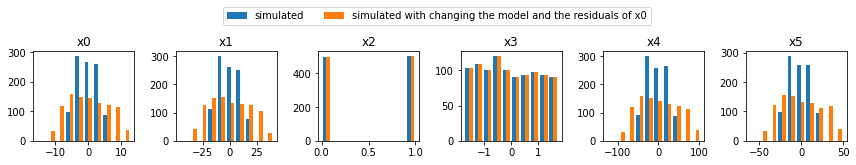

In [13]:
fig, axes = plt.subplots(1, sim_df.shape[1], figsize=(2 * sim_df.shape[1], 2))

for ax, column_name in zip(axes, sim_df.columns):
    ax.hist((sim_df[column_name], sim_df2[column_name]), label=("simulated", "simulated with changing the model and the residuals of x0"))
    ax.set_title(column_name)
    
plt.tight_layout()
axes[0].legend(bbox_to_anchor=(4, 1.4), ncol=2, loc="center")
plt.show()

## Shuffle residuals to be added when simulating
When run() is executed, simulation is performed by adding the training residuals to the predictions. By default, the residuals to be added to the predictions are the training residuals for the same sample. By using the option shuffle_residual, the residuals are shuffled and added together.

In [14]:
sim = CausalBasedSimulator()
sim.train(X, G)

# no shuffling
sim_df = sim.run(shuffle_residual=False)

# shuffling all exogenous variables
sim_df2 = sim.run(shuffle_residual=True)

# shuffling all exogenous variables except a most upstream endogenous variable.
exog = sim.train_result_["x3"]["residual"].copy()
np.random.shuffle(exog)
changing_exog = {
    "x3": exog
}
sim_df3 = sim.run(shuffle_residual=True, changing_exog=changing_exog)

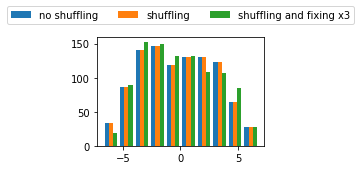

In [15]:
plt.figure(figsize=(3, 2))
plt.hist((sim_df["x0"], sim_df2["x0"], sim_df3["x0"]), label=("no shuffling", "shuffling", "shuffling and fixing x3"))
plt.legend(bbox_to_anchor=(0.5, 1.2), ncol=3, loc="center")
plt.show()

Shuffling or not does not affect the histogram, but fixing the endogenous variables and shuffling the residuals does.